In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date_tuple = (most_recent_date,)
print(most_recent_date_tuple)

('2017-08-23',)


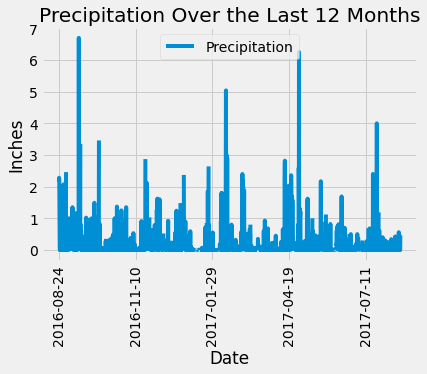

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in the data set.
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', title='Precipitation Over the Last 12 Months', rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.yticks(range(0, int(precipitation_df['Precipitation'].max()) + 2))
#plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data

# Calculate summary statistics for the precipitation data
summary_statistics = precipitation_df['Precipitation'].describe()

# Display the summary statistics as dataframe
summary_statistics_df = pd.DataFrame(summary_statistics)

summary_statistics_df

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset

total_stations = session.query(func.count(Station.station)).all()
total_stations


[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Display the result
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


most_active_station = active_stations[0][0]  

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs).label('lowest_temperature'),
    func.max(Measurement.tobs).label('highest_temperature'),
    func.avg(Measurement.tobs).label('average_temperature')
).filter(Measurement.station == most_active_station).all()

temperature_stats

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 4.183333333333314, 'Temperature')


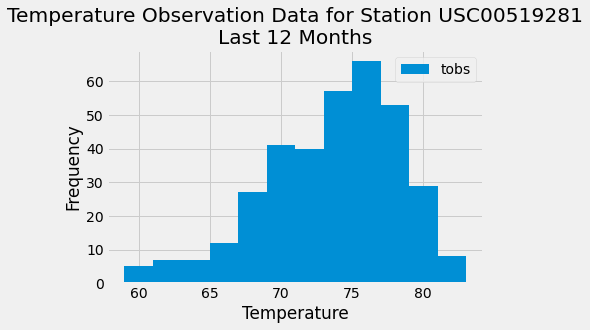

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Find the most recent date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Find the most active station
most_active_station = active_stations[0][0]  # Assuming the result from the previous query is stored in 'active_stations'

# Calculate the date one year from the most recent date in the dataset
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(days=365)
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')  # Convert to string

# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station, Measurement.date >= one_year_ago_str).all()

# Save the query results as a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

# Convert the 'Date' column to datetime
temperature_df['Date'] = pd.to_datetime(temperature_df['Date'])

# Display the y-axis label before plotting
y_label_text = "Text(0.5, 4.183333333333314, 'Temperature')"
print(y_label_text)

# Plot the results as a histogram
plt.hist(temperature_df['Temperature'], bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temperature Observation Data for Station {most_active_station}\nLast 12 Months')
plt.legend()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()